# PETS for all samples

In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os



In [2]:
torch.cuda.empty_cache()

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class GaussianNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GaussianNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_log_std = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_log_std(x)
        std = torch.exp(log_std).clamp(min=1e-6, max=1.0)
        return mean, std

class EnsembleGaussianNetwork(nn.Module):
    def __init__(self, num_models, input_dim, hidden_dim, output_dim):
        super(EnsembleGaussianNetwork, self).__init__()
        self.models = nn.ModuleList([GaussianNetwork(input_dim, hidden_dim, output_dim) for _ in range(num_models)])
    
    def forward(self, x):
        means, stds = [], []
        for model in self.models:
            mean, std = model(x)
            means.append(mean)
            stds.append(std)
        means = torch.stack(means)
        stds = torch.stack(stds)
        return means, stds
    


EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)


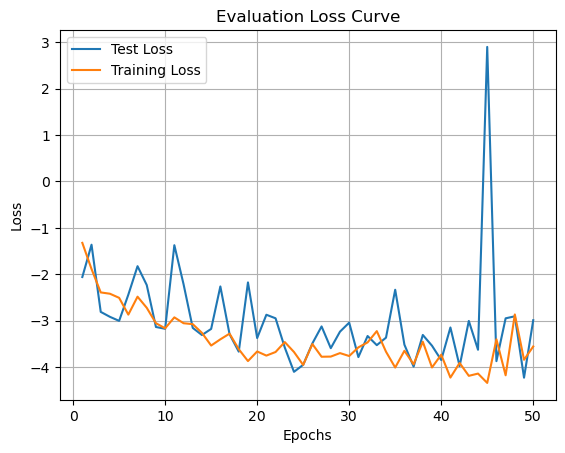

Mean Squared Error (MSE): 0.0040744151920080185
R-squared: 0.6993968531267635


In [4]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
env_names = ['CartPole-v1', 'MountainCar-v0']
env_names = ['MountainCarContinuous-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

time_taken = 'NN Model, Environment Name, No of Samples, Time Taken\n'

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32


    for num_samples in num_samples_list:
        # Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)
            
#         with open(env_name + '_' + num_samples + '_g=5_train_dataset.pkl', 'rb') as f:
#             train_dataset_loaded = pickle.load(f)

#         with open(env_name + '_' + num_samples + '_g=5_test_dataset.pkl', 'rb') as f:
#             test_dataset_loaded = pickle.load(f)

        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = (env.observation_space.shape[0] + 2)
        num_layers = 3
        num_nodes = 20
        activation = nn.ReLU()
        num_ensembles = 5
        learning_rate = 0.01

        model = EnsembleGaussianNetwork(num_ensembles, input_size, num_nodes, output_size).to(device)
        print(model)


        # Define loss function and optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                means, stds = model(inputs)
                loss = 0
                
                if torch.isnan(means).any():
                    print("NaNs found in means")
                    # Handle NaNs, e.g., by setting them to zero or some other value
                    means = torch.nan_to_num(means, nan=0.0)

                if torch.isnan(stds).any():
                    print("NaNs found in stds")
                    # Handle NaNs, e.g., by setting them to zero or some other value
                    stds = torch.nan_to_num(stds, nan=1.0)
                    
                for mean, std in zip(means, stds):
                    distribution = torch.distributions.Normal(mean, std)
                    loss += -distribution.log_prob(labels).mean()

                if torch.isnan(loss).any():
                    print("NaN detected during training")
                    print("Inputs:", inputs)
                    print("Mean Prediction:", mean_pred)
                    print("Std Prediction:", std_pred)
                    break

                loss.backward()
                optimizer.step()
                running_loss += loss.item()
#             if torch.isnan(loss).any():
#                 torch.save(model.state_dict(), f'pets_{env_name}_epoch_{epoch+1}.pth')
#                 break
            epoch_train_loss = running_loss / len(train_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    mean_pred, std_pred = model(inputs)
#                     print(mean_pred, std_pred)

                    if torch.isnan(mean_pred).any():
                        print("NaNs found in means")
                        # Handle NaNs, e.g., by setting them to zero or some other value
                        mean_pred = torch.nan_to_num(mean_pred, nan=0.0)

                    if torch.isnan(std_pred).any():
                        print("NaNs found in stds")
                        # Handle NaNs, e.g., by setting them to zero or some other value
                        std_pred = torch.nan_to_num(std_pred, nan=1.0)

                    test_loss = 0
                    for mean, std in zip(mean_pred, std_pred):
                        distribution = torch.distributions.Normal(mean, std)
                        test_loss += -distribution.log_prob(labels).mean()
                    
#                     print(test_loss)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

#             if (epoch + 1) % save_interval == 0:
#                 # Save model state
#                 torch.save(model.state_dict(), f'pets_{env_name}_{num_samples}_epoch_{epoch+1}.pth')

            test_losses.append(epoch_test_loss)
            print("Epoch " + str(epoch) + ' train loss :' + str(loss) + ' test loss : ' + str(test_loss))
        
        end_time = time.time()
        total_time = end_time - start_time
        
        time_taken =  time_taken + 'Pets ,' + env_name + ' ,' + num_samples + ' ,' + str(total_time) + '\n'
            
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('pets_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
#         plt.savefig('pets_'+ env_name + '_' + num_samples + '_g=5' + '_evaluation_loss_curve.png')
        plt.show()
        
#         predictions = []
#         true_labels = []

#         # Iterate over test data
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 #predictions.extend(outputs.cpu().numpy())
#                 #true_labels.extend(labels.cpu().numpy())
#                 #predictions.extend(outputs)
#                 #true_labels.extend(labels)
#                 mean_pred, std_pred = outputs[0].cpu()
                
#                 if torch.isnan(mean_pred).any():
#                         print("NaNs found in means")
#                         # Handle NaNs, e.g., by setting them to zero or some other value
#                         mean_pred = torch.nan_to_num(mean_pred, nan=0.0)

#                 if torch.isnan(std_pred).any():
#                     print("NaNs found in stds")
#                     # Handle NaNs, e.g., by setting them to zero or some other value
#                     std_pred = torch.nan_to_num(std_pred, nan=1.0)

#                 for mean, std in zip(mean_pred, std_pred):
#                     distribution = torch.distributions.Normal(mean, std)
                    
#                 predictions.extend(prediction_tensor.numpy())
#                 true_labels.extend(labels.cpu().numpy())

#         # Convert lists to numpy arrays
#         predictions = np.array(predictions)
#         true_labels = np.array(true_labels)

#         # Calculate Mean Squared Error (MSE) and R-squared
#         mse = mean_squared_error(true_labels, predictions)
#         r2 = r2_score(true_labels, predictions)

#         print(f"Mean Squared Error (MSE): {mse}")
#         print(f"R-squared: {r2}")
        
        model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'.pth' 
#         model_weights_file_path = 'pets_'+ env_name + '_' + num_samples + '_g=5' +'.pth' 
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)
        
#         break
#     break

with open('timetaken_pets', 'w') as file:
    file.write(time_taken)

# Monte Carlo Dropout for all samples

In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

import time

In [2]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class MC_Dropout_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_network):
        super(MC_Dropout_Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        self.num_network = num_network
        
        # Define the layers
        self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))
        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)

    def forward(self, x):
        total_output = 0.0
        for i in range(self.num_network):
            x_temp = x
            x_temp = self.activation(self.input_layer(x_temp))
            for hidden_layer in self.hidden_layers:
                x_temp = self.activation(hidden_layer(x_temp))
            output = self.output_layer(x_temp)
            total_output += output
        average_output = total_output / self.num_network
        return average_output


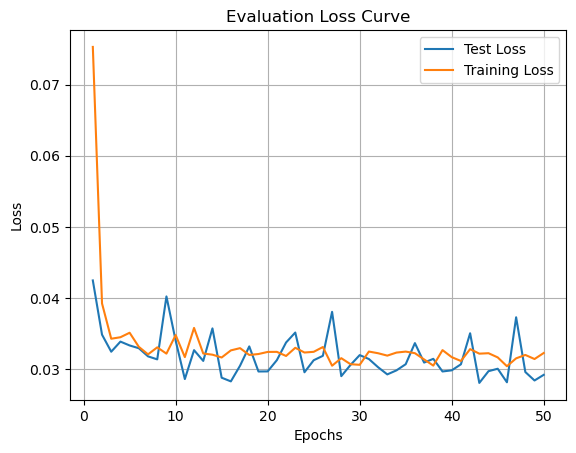

Mean Squared Error (MSE): 0.02948051132261753
R-squared: 0.3785318997181358


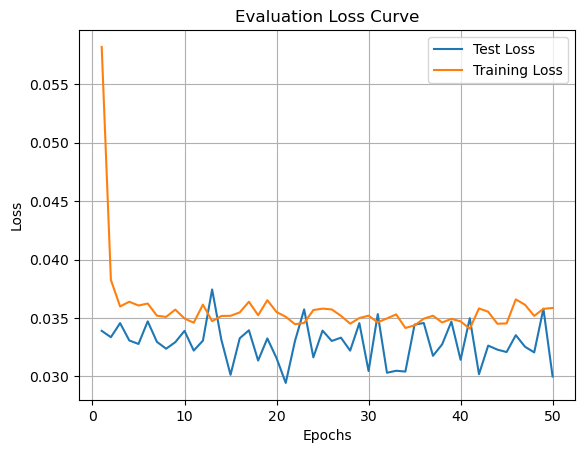

Mean Squared Error (MSE): 0.03196311369538307
R-squared: 0.3916589321990433


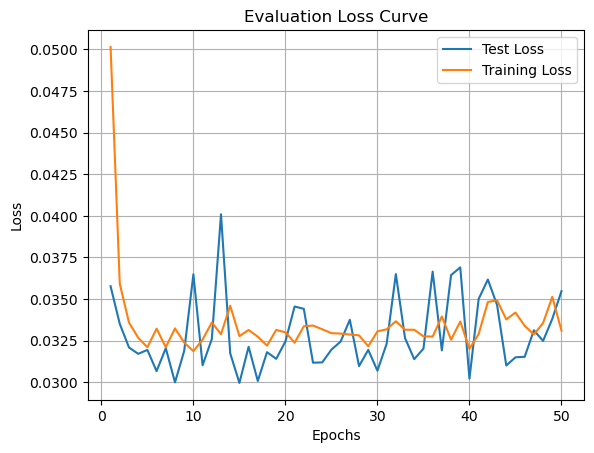

Mean Squared Error (MSE): 0.035207394510507584
R-squared: 0.4162106228434614


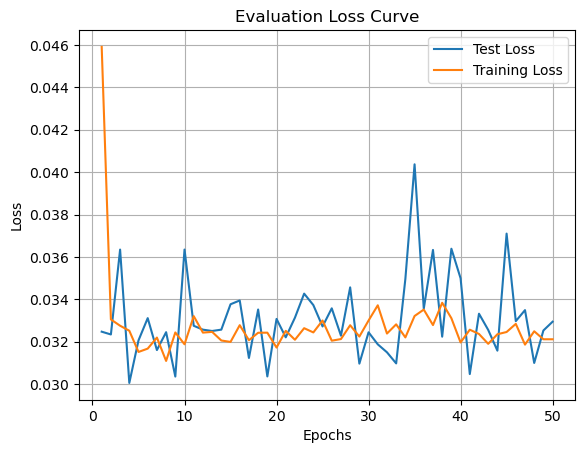

Mean Squared Error (MSE): 0.032084230333566666
R-squared: 0.3848914581702432


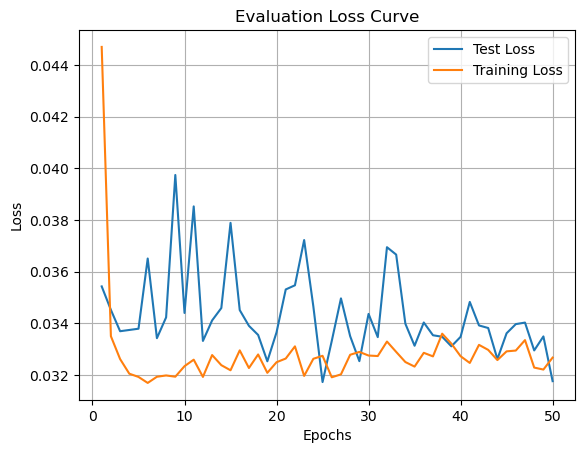

Mean Squared Error (MSE): 0.03161022067070007
R-squared: 0.38271154780665945


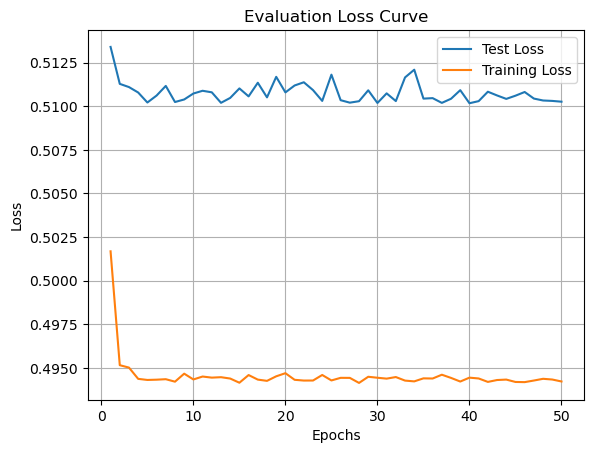

Mean Squared Error (MSE): 0.5102344751358032
R-squared: -0.008175512143946129


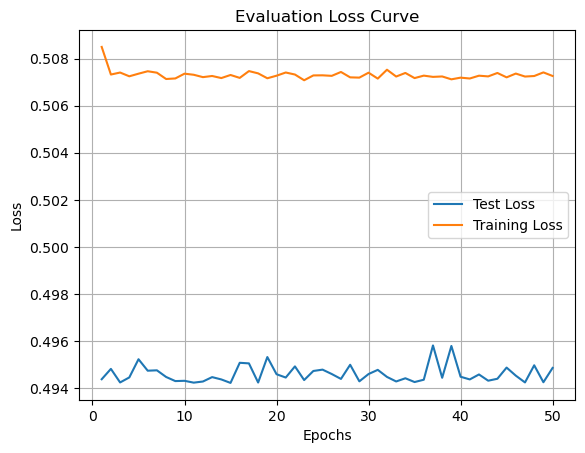

Mean Squared Error (MSE): 0.4948493540287018
R-squared: -0.021681293099970134


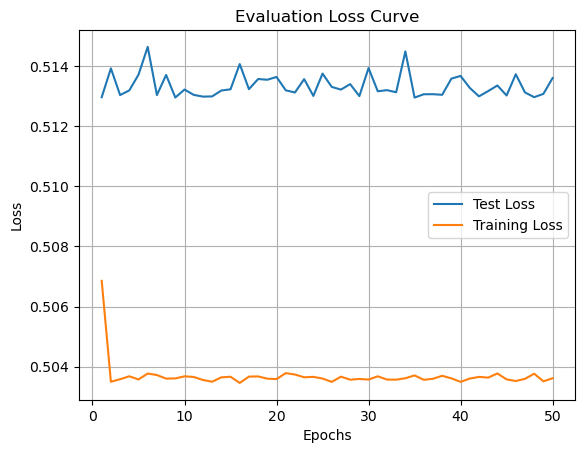

Mean Squared Error (MSE): 0.5129263997077942
R-squared: -0.00851497867645079


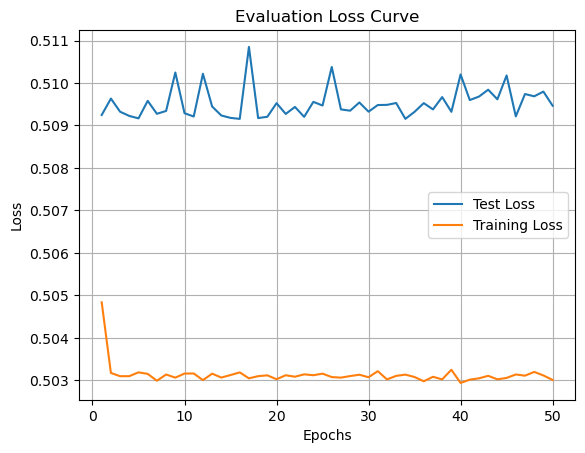

Mean Squared Error (MSE): 0.5094648003578186
R-squared: -0.010693666858926809


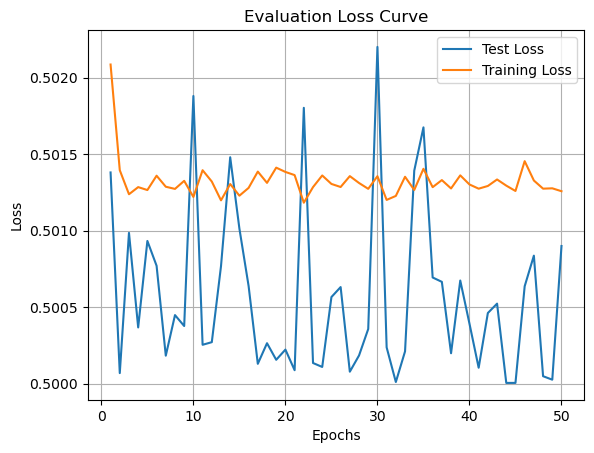

Mean Squared Error (MSE): 0.5006860494613647
R-squared: -0.03503846676481487


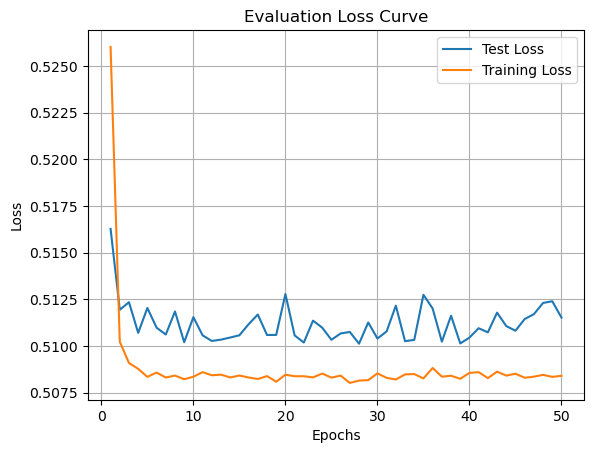

Mean Squared Error (MSE): 0.5113394260406494
R-squared: 0.248627698342058


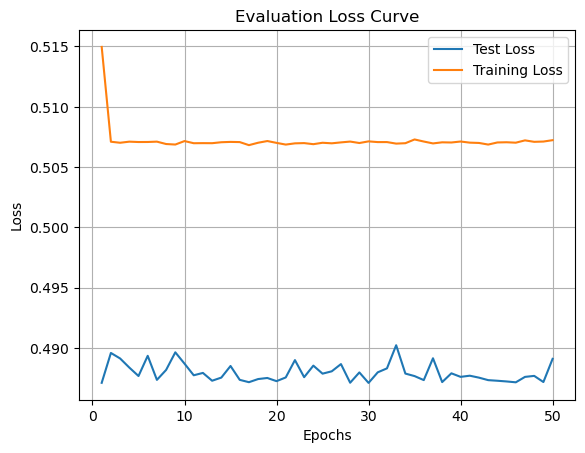

Mean Squared Error (MSE): 0.48910969495773315
R-squared: 0.24793057074511388


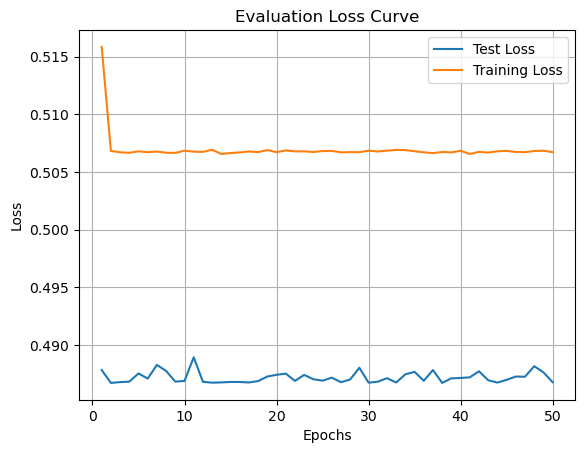

Mean Squared Error (MSE): 0.4865299463272095
R-squared: 0.24993072481863543


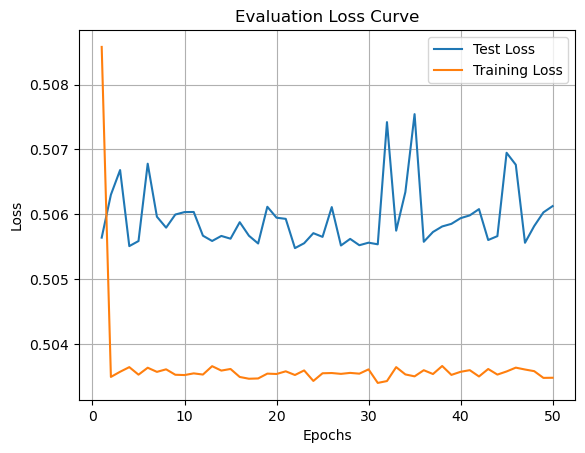

Mean Squared Error (MSE): 0.5061249732971191
R-squared: 0.24935258472278504


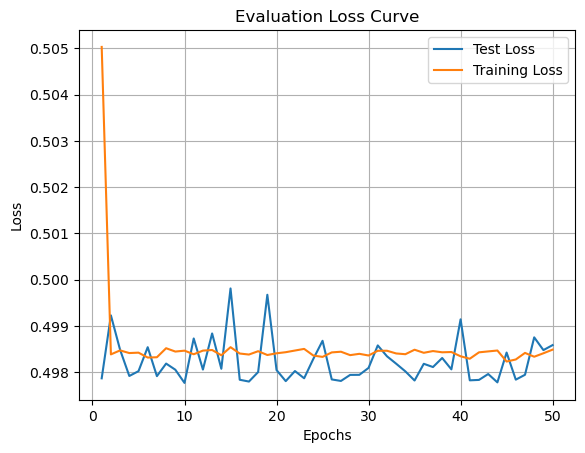

Mean Squared Error (MSE): 0.4983000159263611
R-squared: 0.2491475771843556


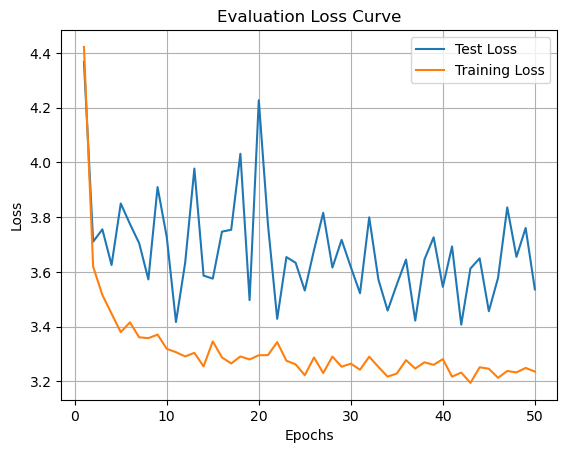

Mean Squared Error (MSE): 3.4497807025909424
R-squared: 0.15174950521612915


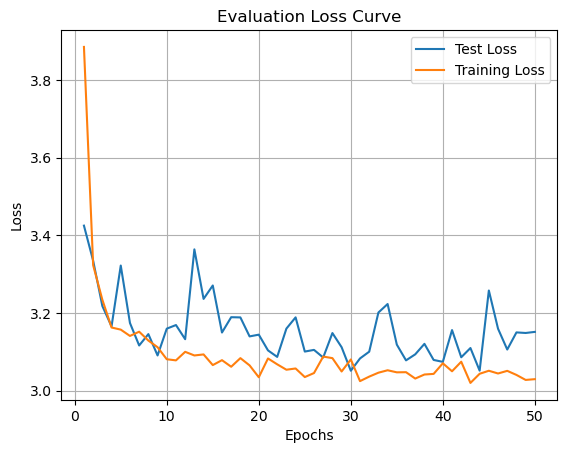

Mean Squared Error (MSE): 3.156620979309082
R-squared: 0.21421887343471643


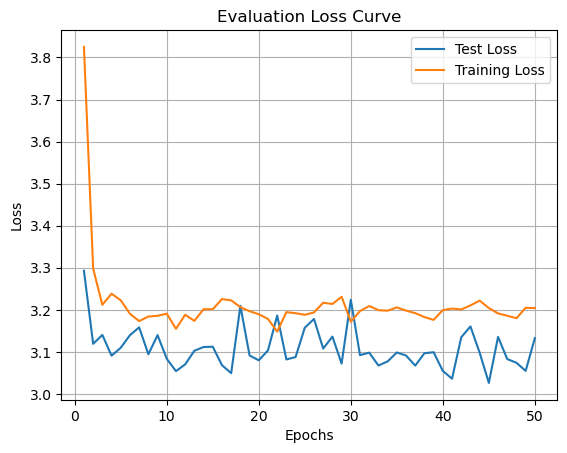

Mean Squared Error (MSE): 3.1108970642089844
R-squared: 0.2105823208684697


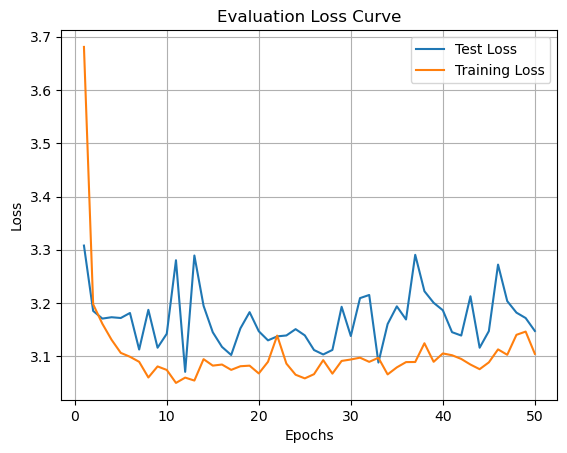

Mean Squared Error (MSE): 3.13167142868042
R-squared: 0.2192048719131447


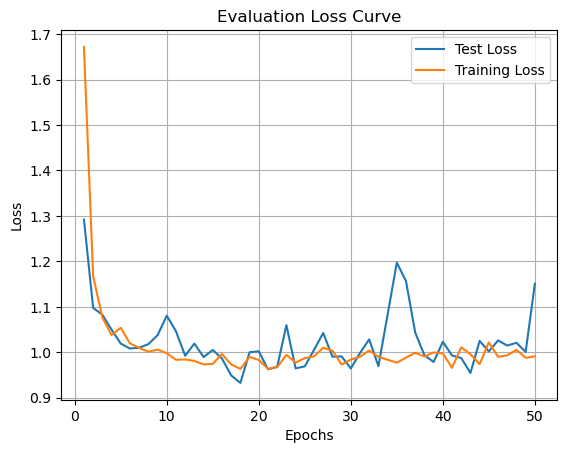

Mean Squared Error (MSE): 1.1634628772735596
R-squared: 0.46124299790070483


In [4]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

time_taken = 'NN Model, Environment Name, No of Samples, Time Taken\n'

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32

    
    for num_samples in num_samples_list:
        #Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)
            
#         with open(env_name + '_' + num_samples + '_g=5_train_dataset.pkl', 'rb') as f:
#             train_dataset_loaded = pickle.load(f)

#         with open(env_name + '_' + num_samples + '_g=5_test_dataset.pkl', 'rb') as f:
#             test_dataset_loaded = pickle.load(f)
        
        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 1


        # Instantiate the model
        model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        start_time = time.time()
        
        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            epoch_train_loss = running_loss / len(train_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss = criterion(outputs, labels)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

#             if (epoch + 1) % save_interval == 0:
#                 # Save model state
#                 torch.save(model.state_dict(), f'montecarlodropout_{env_name}_{num_samples}_epoch_{epoch+1}.pt')

            test_losses.append(epoch_test_loss)
        
        end_time = time.time()
        total_time = end_time - start_time
        
        time_taken =  time_taken + 'Pets ,' + env_name + ' ,' + num_samples + ' ,' + str(total_time) + '\n'
            
            
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('montecarlodropout_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
#         plt.savefig('montecarlodropout_'+ env_name + '_' + num_samples + '_g=5_evaluation_loss_curve.png')
        plt.show()


        # Lists to store predictions and true labels
        predictions = []
        true_labels = []

        # Iterate over test data
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Calculate Mean Squared Error (MSE) and R-squared
        mse = mean_squared_error(true_labels, predictions)
        r2 = r2_score(true_labels, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared: {r2}")

        model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 
#         model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples + '_g=5' +'.pth' 
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)
        
#         break
#     break

with open('timetaken_montecarlo', 'w') as file:
    file.write(time_taken)

# Bayesian models for all samples

In [9]:
import gym
!pip install torchbnn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchbnn as bnn

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

import time

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [10]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation):
        super(BayesianNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        
        # Define the layers
#         self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.input_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
#           self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=hidden_layer_nodes))
#        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)
        self.output_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=output_size)
        

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        output = self.output_layer(x)
        return output


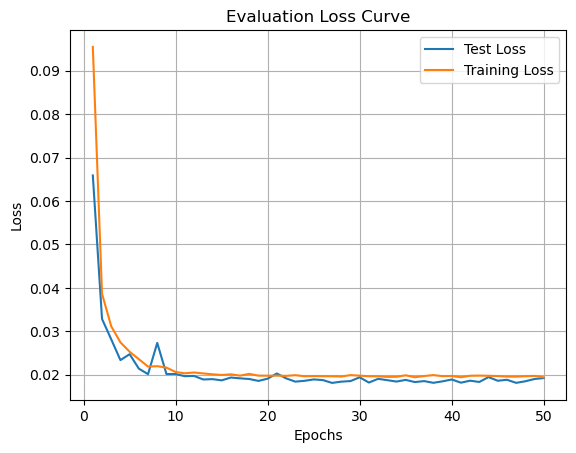

Mean Squared Error (MSE): 0.013785287737846375
R-squared: 0.4860790679148022
bayesian_CartPole-v1_10k.pth


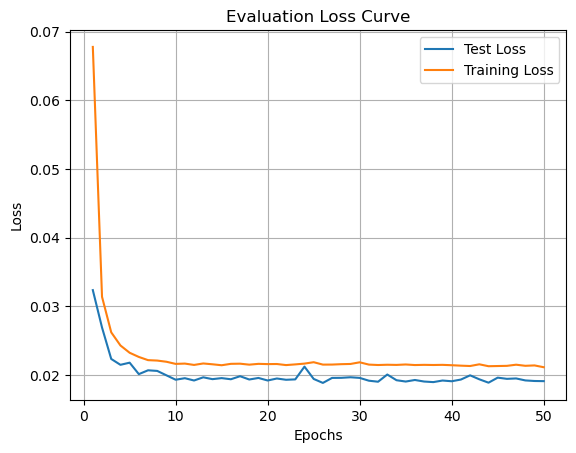

Mean Squared Error (MSE): 0.013400348834693432
R-squared: 0.4740608100084525
bayesian_CartPole-v1_20k.pth


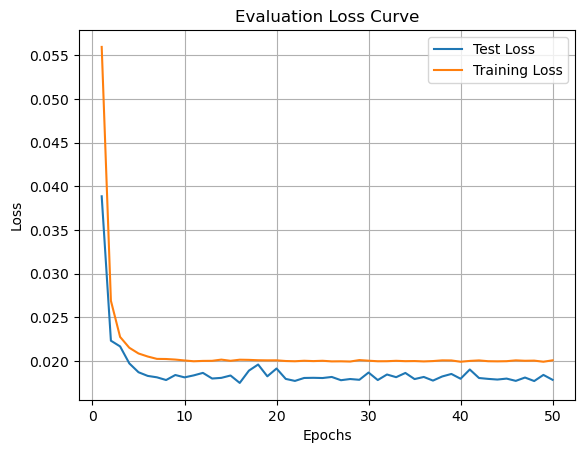

Mean Squared Error (MSE): 0.012569244019687176
R-squared: 0.4709750896455545
bayesian_CartPole-v1_30k.pth


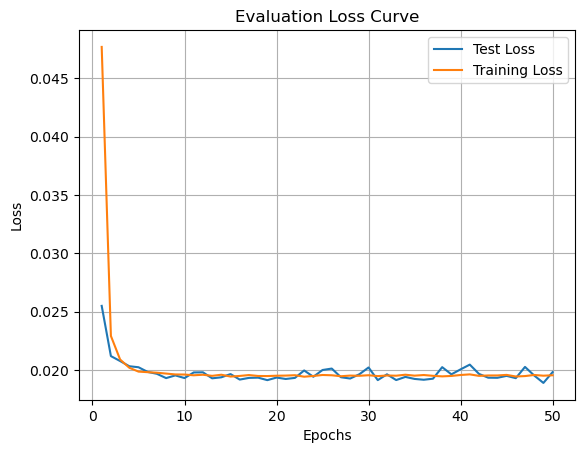

Mean Squared Error (MSE): 0.014312776736915112
R-squared: 0.4565935833001728
bayesian_CartPole-v1_40k.pth


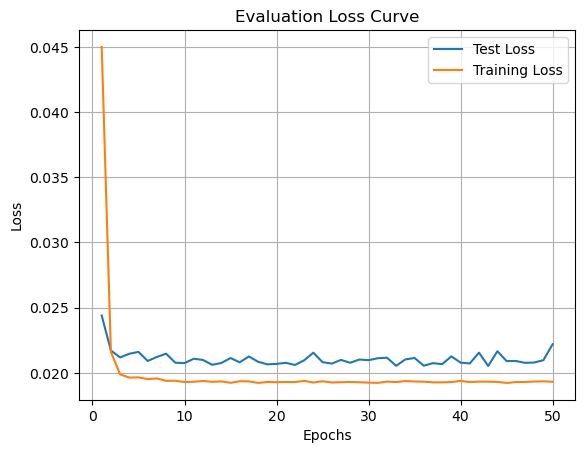

Mean Squared Error (MSE): 0.016482168808579445
R-squared: 0.42588892349767987
bayesian_CartPole-v1_50k.pth


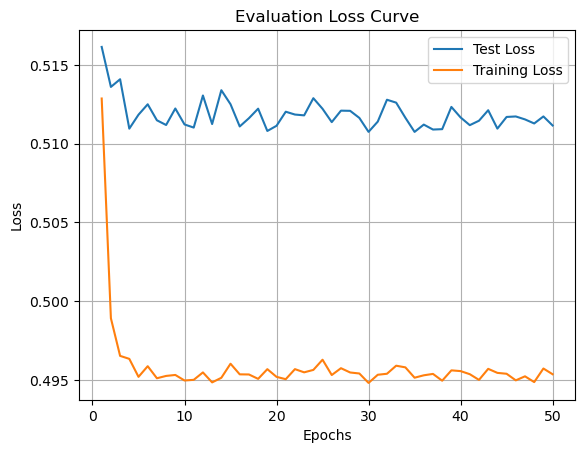

Mean Squared Error (MSE): 0.5105016231536865
R-squared: -0.0341506268001707
bayesian_MountainCarContinuous-v0_10k.pth


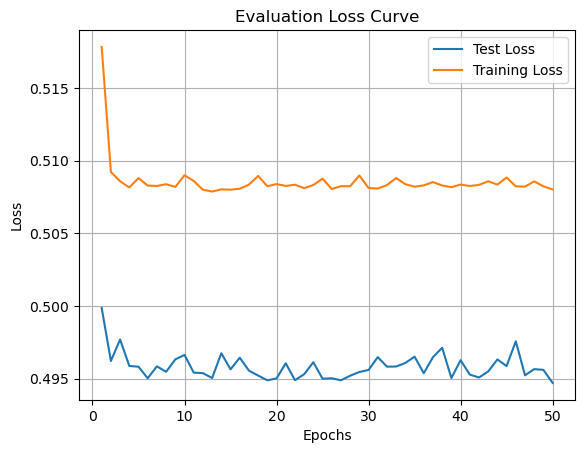

Mean Squared Error (MSE): 0.49435147643089294
R-squared: -0.014734028408625643
bayesian_MountainCarContinuous-v0_20k.pth


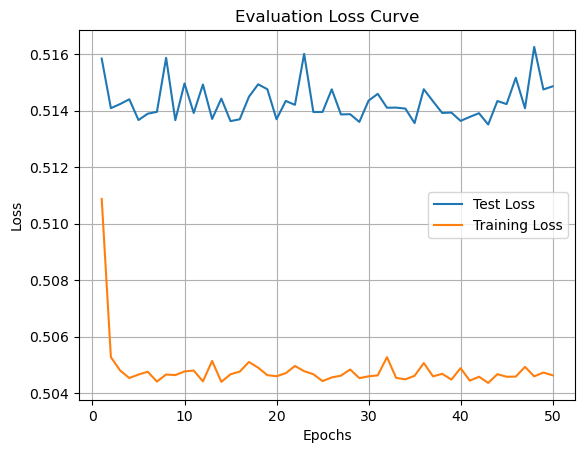

Mean Squared Error (MSE): 0.5129883885383606
R-squared: -0.019600491553620814
bayesian_MountainCarContinuous-v0_30k.pth


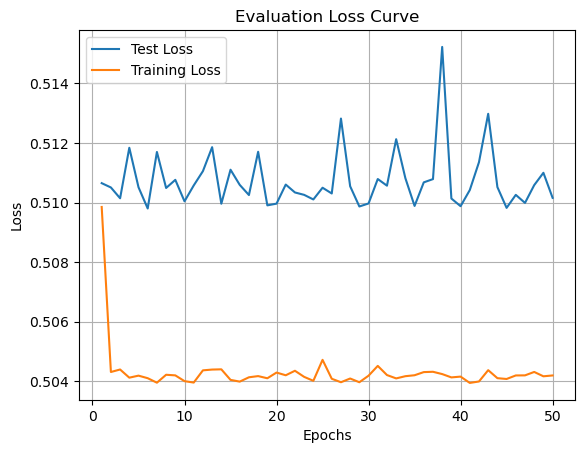

Mean Squared Error (MSE): 0.5092452168464661
R-squared: -0.013645379624066423
bayesian_MountainCarContinuous-v0_40k.pth


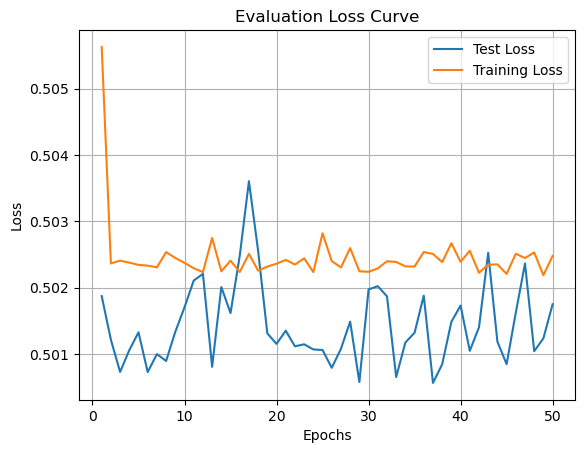

Mean Squared Error (MSE): 0.5008118152618408
R-squared: -0.03801195812983266
bayesian_MountainCarContinuous-v0_50k.pth


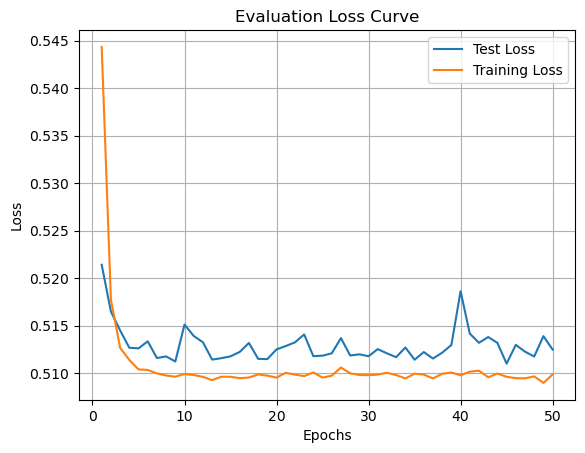

Mean Squared Error (MSE): 0.5109386444091797
R-squared: -0.0009186738643878756
bayesian_MountainCar-v0_10k.pth


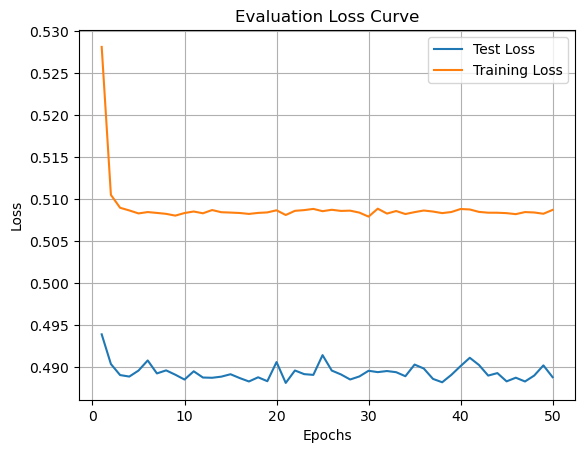

Mean Squared Error (MSE): 0.48797714710235596
R-squared: -0.0008837776623234483
bayesian_MountainCar-v0_20k.pth


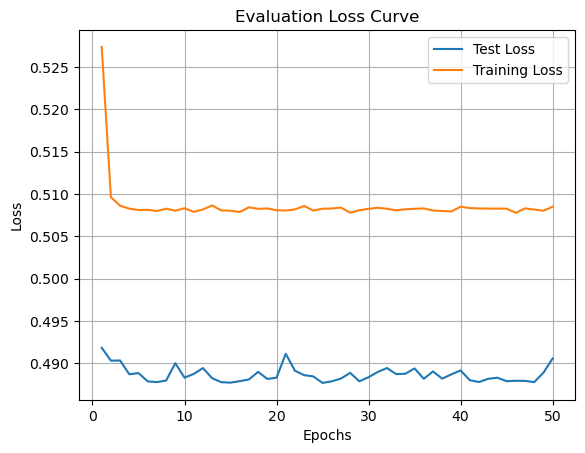

Mean Squared Error (MSE): 0.4883282482624054
R-squared: -0.0015659467472428634
bayesian_MountainCar-v0_30k.pth


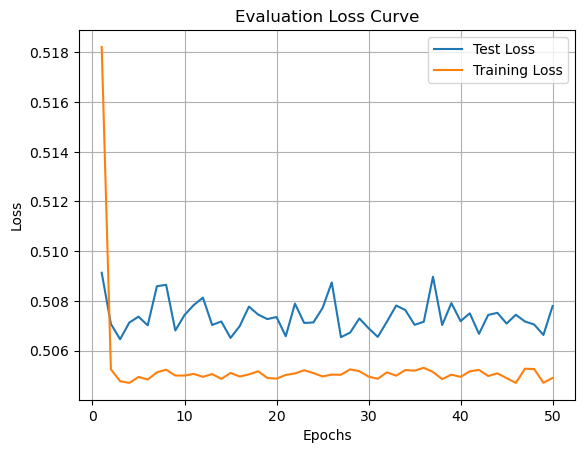

Mean Squared Error (MSE): 0.5061370134353638
R-squared: -0.0005276054619738901
bayesian_MountainCar-v0_40k.pth


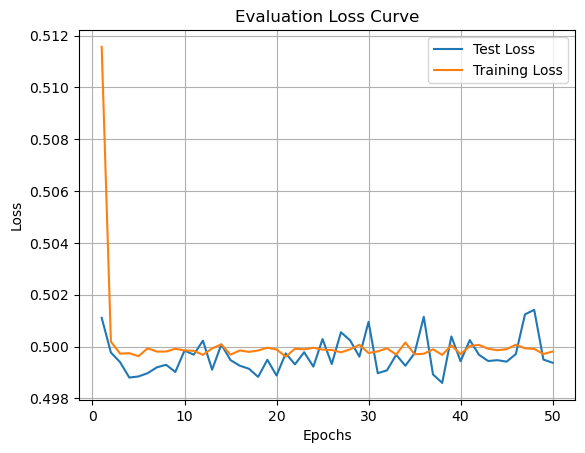

Mean Squared Error (MSE): 0.4977717995643616
R-squared: -0.0002687643255514238
bayesian_MountainCar-v0_50k.pth


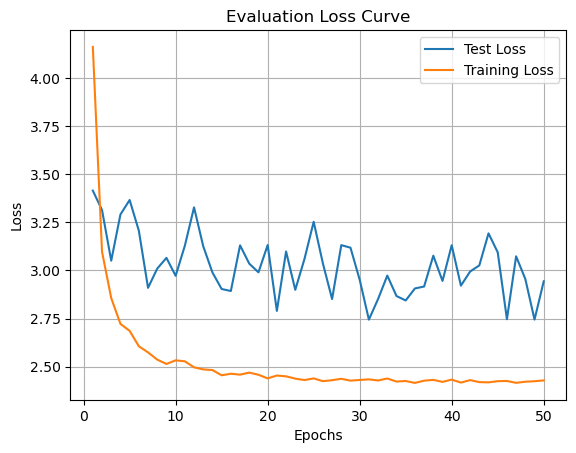

Mean Squared Error (MSE): 2.927727699279785
R-squared: 0.2105516509958257
bayesian_Pendulum-v1_10k.pth


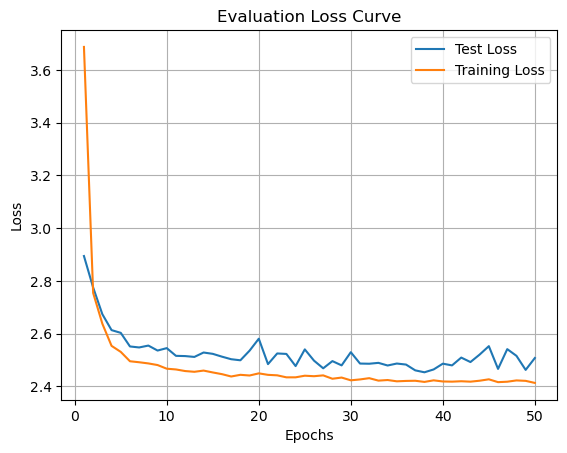

Mean Squared Error (MSE): 2.476933240890503
R-squared: 0.2677969003188145
bayesian_Pendulum-v1_20k.pth


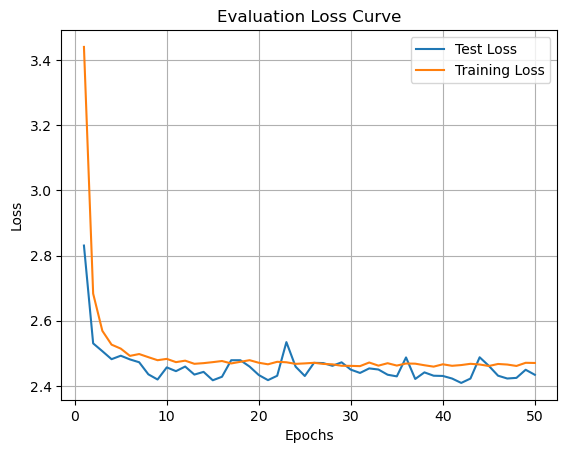

Mean Squared Error (MSE): 2.4056649208068848
R-squared: 0.27335146119078757
bayesian_Pendulum-v1_30k.pth


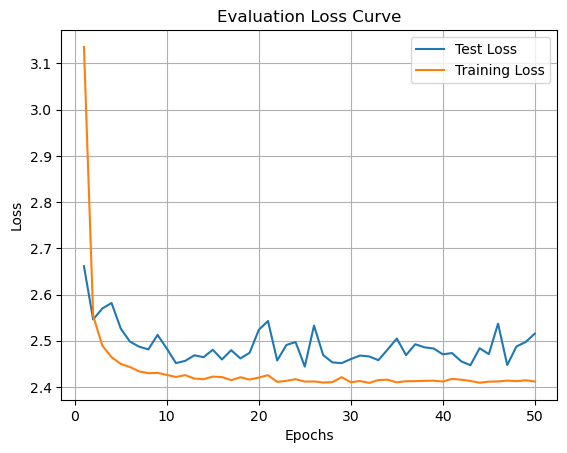

Mean Squared Error (MSE): 2.4851927757263184
R-squared: 0.2733211933691626
bayesian_Pendulum-v1_40k.pth


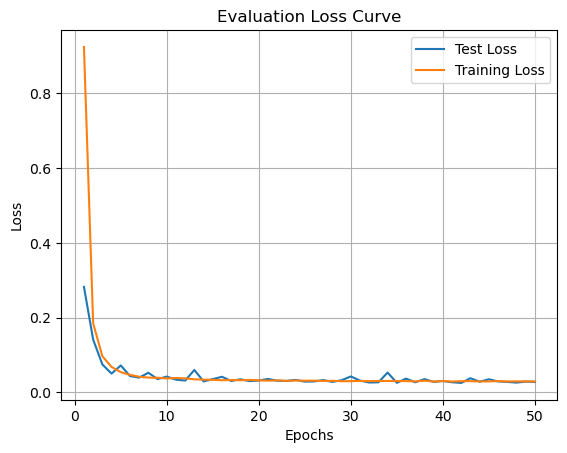

Mean Squared Error (MSE): 0.006820983253419399
R-squared: 0.793732242639175
bayesian_Pendulum-v1_50k.pth


In [12]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

time_taken = 'NN Model, Environment Name, No of Samples, Time Taken\n'

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32

    for num_samples in num_samples_list:
        # Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)
            
#         with open(env_name + '_' + num_samples + '_g=5_train_dataset.pkl', 'rb') as f:
#             train_dataset_loaded = pickle.load(f)

#         with open(env_name + '_' + num_samples + '_g=5_test_dataset.pkl', 'rb') as f:
#             test_dataset_loaded = pickle.load(f)

        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 5

        # Instantiate the model
        model = BayesianNN(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation).to(device)

        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        kl_weight = 0.01

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        start_time = time.time()
        
        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            epoch_train_loss = running_loss / len(train_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

#             if (epoch + 1) % save_interval == 0:
#                 # Save model state
#                 torch.save(model.state_dict(), f'bayesian_{env_name}_{num_samples}_epoch_{epoch+1}.pt')

            test_losses.append(epoch_test_loss)
    
        end_time = time.time()
        total_time = end_time - start_time
        
        time_taken =  time_taken + 'Bayesian ,' + env_name + ' ,' + num_samples + ' ,' + str(total_time) + '\n'
   
    
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('bayesian_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
#         plt.savefig('bayesian_'+ env_name + '_' + num_samples + '_g=5_evaluation_loss_curve.png')
        plt.show()
        
        # Switch model to evaluation mode
        #model.eval()

        # Lists to store predictions and true labels
        predictions = []
        true_labels = []

        # Iterate over test data
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Calculate Mean Squared Error (MSE) and R-squared
        mse = mean_squared_error(true_labels, predictions)
        r2 = r2_score(true_labels, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared: {r2}")
        
        model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'.pth' 
#         model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples + '_g=5' +'.pth' 
        print(model_weights_file_path)
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)
        
#         break
#     break

In [13]:

with open('timetaken_bayesian', 'w') as file:
    file.write(time_taken)

In [14]:
print(start_time)

1718023867.0755105


In [15]:
print(end_time)

1718024419.2526069
